In [1]:
from mcmc import initialize_slab, spin_flip, mcmc_run
from catkit.gen.adsorption import get_adsorption_sites

import numpy as np

In [2]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab 
state = np.zeros(len(coords), dtype=int)

temp = 300
pot = 2

# perform 5 test iterations
site1 = len(state)-1
site2 = len(state)-2

# add to two sites
state, slab, energy = spin_flip(state, slab, temp, pot, save_cif=True, iter=1, site_idx=site1, testing=True)
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=2, site_idx=site2, testing=True)

# remove from 1st site
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=3, site_idx=site1, testing=True)
# remove from 2nd site
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=4, site_idx=site2, testing=True)

# add to 1st site again
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=5, site_idx=site1, testing=True)

/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/Users/xiaochendu/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In pristine slab, there are a total of 64 sites

idx is 63 at [ 1.27798944  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]

idx is 62 at [ 3.83396832  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]
site is not filled, attempting to adsorb
current slab has 65 atoms
proposed slab has 66 atoms
after proposed state is

In [3]:
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab 
state = np.zeros(len(coords), dtype=int)

temp = 1
pot = 0.5

# try with energy
# add to two sites
state, slab, energy = spin_flip(state, slab, temp, pot, save_cif=True, iter=1, site_idx=site1, testing=False)
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=2, site_idx=site2, testing=False)

state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=3, site_idx=site1, testing=False)
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=4, site_idx=site2, testing=False)
state, slab, energy = spin_flip(state, slab, temp, pot, prev_energy=energy, save_cif=True, iter=5, site_idx=site1, testing=False)

In pristine slab, there are a total of 64 sites

idx is 63 at [ 1.27798944  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 64]
prev energy is -210.23276418379697
curr energy is -212.94567025612895
energy diff is -2.7129060723319753
potential is 0.5
delta_N 1
k_b T 1
base probability is 24.85120077577542
state changed!

idx is 62 at [ 3.83396832  8.94592609 20.42205   ] with connectivity 4
before proposed state is
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [4]:
mcmc_run(num_runs=1, temp=1, pot=0.5, slab=None)

initializing slab
In pristine slab, there are a total of 64 sites
running for 64 iterations per run over a total of 1 iterations

idx is 5 at [ 2.55597888  2.55597888 20.42205   ] with connectivity 1
before proposed state is
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
site is not filled, attempting to adsorb
current slab has 64 atoms
proposed slab has 65 atoms
after proposed state is
[ 0  0  0  0  0 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
prev energy is -210.23276418379697
curr energy is -211.64331312287635
energy diff is -1.4105489390793764
potential is 0.5
delta_N 1
k_b T 1
base probability is 6.7567968505335125
state changed!

idx is 50 at [ 1.27798944  6.3899472  20.42205   ] with connectivity 4
before proposed state is
[ 0  0  0  0  0 64  0  0  0  0  0  0  0

TypeError: float() argument must be a string or a number, not 'Atom'

In [2]:
from time import perf_counter

# run for a range of temperatures with chain size = 1000 and using a 10 x 10 lattice
temps = np.arange(0.2, 5.2, 0.2)
num_runs = 1000
lattice_width = 10
N = lattice_width**2

energy_results = np.random.rand(len(temps), num_runs)
energy_sq_results = np.random.rand(len(temps), num_runs)
starting_lattice = None

# iterate through different temperatures
for i, temp in reversed(list(enumerate(temps))):
    start = perf_counter()
    history, energy, energy_sq, net_mag, mag_sq = mcmc_run(num_runs=num_runs, temp=temp, \
        lattice_width=lattice_width, lattice=starting_lattice)
    # intitialize with previous temp simulation
    starting_lattice = history[-1]
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds for temp = {temp}")
    energy_results[i, :] = energy
    energy_sq_results[i, :] = energy_sq

# Also iterate through different chemical potentials

energy_sq_mean = np.mean(energy_sq_results, axis=1)
energy_mean = np.mean(energy_results, axis=1)
energy_mean_sq = np.power(energy_mean, 2)

energy_per_spin = energy_mean/N

# for normalizing the activities
inverse_kbT_sq = 1/np.square(temps)
C_v = (energy_sq_mean - energy_mean_sq)*inverse_kbT_sq
C_v_per_spin = C_v/N

initializing lattice
Time taken = 1.2047371459999994 seconds for temp = 5.000000000000001
Time taken = 0.9832059259999966 seconds for temp = 4.800000000000001
Time taken = 1.0037778889999913 seconds for temp = 4.6000000000000005
Time taken = 0.9537772200000063 seconds for temp = 4.4
Time taken = 1.0364955370000075 seconds for temp = 4.2
Time taken = 0.9909937249999956 seconds for temp = 4.0
Time taken = 1.0559076030000085 seconds for temp = 3.8000000000000003
Time taken = 0.9858881780000104 seconds for temp = 3.6000000000000005
Time taken = 1.0058716359999949 seconds for temp = 3.4000000000000004
Time taken = 1.0012199729999907 seconds for temp = 3.2
Time taken = 0.9881924529999822 seconds for temp = 3.0000000000000004
Time taken = 0.9866011809999975 seconds for temp = 2.8000000000000003
Time taken = 0.9761906409999881 seconds for temp = 2.6000000000000005
Time taken = 0.9632951159999834 seconds for temp = 2.4000000000000004
Time taken = 0.9645457559999784 seconds for temp = 2.2
Time t

/var/folders/85/zd91wmvn09956_q0gy77y3080000gp/T/ipykernel_43994/3021409286.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


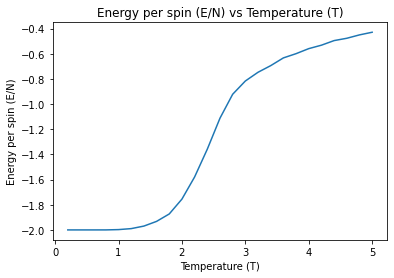

In [3]:
# do the plots
fig, ax = plt.subplots()
ax.plot(temps, energy_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Energy per spin (E/N)")
ax.set_title("Energy per spin (E/N) vs Temperature (T)")
fig.show()
# fig.savefig("energy_per_spin")
fig.savefig("energy_per_spin_10x10")

/var/folders/85/zd91wmvn09956_q0gy77y3080000gp/T/ipykernel_43994/4164975783.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


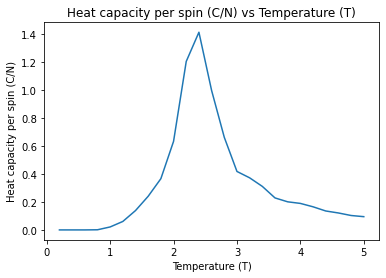

In [4]:
fig, ax = plt.subplots()
ax.plot(temps, C_v_per_spin)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Heat capacity per spin (C/N)")
ax.set_title("Heat capacity per spin (C/N) vs Temperature (T)")
fig.show()
# fig.savefig("c_v_per_spin")
fig.savefig("c_v_per_spin_10x10")